In [2]:
import numpy as np # linear algebra
import pandas as pd
import torch
import os
from ml_eke import *
from tqdm import tqdm
import matplotlib.pyplot as plt


In [287]:
 columns = [
           'MKE_sfc',
           'Rd_dx_sfc',
           'relative_vorticity_sfc',
           'grad_SSH_sfc',
           ]

device = 'cuda:0'
model_path = './ml_eke/nn/pytorch/ResNet_4-100_mse_cf_all_4_noslope.pkl'
#model_path = './ml_eke/nn/pytorch/ResNetExtraSmall_4-20_mse_cf_all_4_noslope.pkl'
model_name = os.path.basename(model_path).split('.')[0]

model_mse = torch.load(model_path, map_location=torch.device(device))

datapaths_2_3 = ('/lus/scratch/arigazzi/ncar/data/2_3_SSH/', '/lus/scratch/arigazzi/ncar/data/2_3_SSH/')
first_suffixes_2_3 = ('_17_001.nc', '_17_001.nc')
datapaths_1_4 = ('/lus/scratch/arigazzi/ncar/data/1_4_SSH/', '/lus/scratch/arigazzi/ncar/data/1_4_SSH/')
first_suffixes_1_4 = ('_1916_001.nc', '_1916_001.nc')

datapaths = datapaths_2_3
first_suffixes = first_suffixes_2_3
last_dir = os.path.normpath(datapaths[0]).split(os.sep)[-1]

model_data = pop_data(datapaths[0], datapaths[0], skip_vars = ['x','y','depth','depth_stdev'], extra_pref=None, first_suffix=first_suffixes[0])
# Uncomment if needed
#model_data.extend_inventory(datapaths[1],first_suffix=first_suffixes[1])

scaler =  np.load('ml_eke/nn/data/scaler_cf_all_4_noslope.npy')

num_samples = 1
dataset = get_samples(0, num_samples, columns, model_data, predictands=['MEKE_sfc']).values[:, :len(columns)]
samples, targets, masks = get_samples_2D(0, num_samples, columns, model_data, predictands=['MEKE_sfc'])

feat_avg = scaler[0,:]
feat_sd  = scaler[1,:]

Extracting samples: 100%|██████████| 1/1 [00:00<00:00, 44.29it/s]
Extracting 2D samples: 0it [00:00, ?it/s]


In [288]:
# torchscript
model_mse.eval()
class InferenceCell(torch.nn.Module):
    
    def __init__(self):
        super(InferenceCell, self).__init__()
        self.model = model_mse

        self.feat_avg = torch.tensor(feat_avg, dtype=torch.float32).to(device)
        self.feat_sd = torch.tensor(feat_sd, dtype=torch.float32).to(device)
        
    def forward(self, x):
        # The features for which log of absolute value has to be taken:
        x[:,[2]] = (torch.log(torch.abs(x[:,[2]]))+36.0)*torch.sign(x[:,[2]])
        # The features for which log has to be taken:
        x[:,[0]] = torch.log(x[:,[0]])
        x[:,[3]] = torch.log(x[:,[3]])
        x = (x - self.feat_avg) / self.feat_sd
        x = self.model(x)
        return x

inference_cell = InferenceCell()
traced_sample = dataset[0:10,:].copy()
x = torch.tensor(traced_sample).to(device)
traced_cell = torch.jit.trace(inference_cell, (x))

In [288]:
traced_sample = dataset[0:10,:].copy()
x = torch.tensor(traced_sample).to(device)
print("return: ", traced_cell(x).cpu().detach().numpy())

return:  [[-5.4186087]
 [-5.3253107]
 [-5.1304936]
 [-4.99355  ]
 [-4.84578  ]
 [-4.720312 ]
 [-4.724961 ]
 [-4.785804 ]
 [-5.0283866]
 [-5.2909083]]


In [289]:
save = True
load = False

torchscript_name = f'./ml_eke/nn/pytorch/trained_models/{model_name}.gpu.pt'

last_dir = os.path.normpath(datapaths[0]).split(os.sep)[-1]
if save:
    traced_cell.save(torchscript_name)
    
if load:
    traced_cell = torch.jit.load(f'./ml_eke/nn/pytorch/trained_models/{model_name}.gpu.pt')
    


In [290]:
from time import time


XX = torch.tensor(dataset[0:20000,:]).to(device)

t1 = time()
y = traced_cell(XX)
t2 = time()

y = y.detach().cpu().numpy()
print(f'Elapsed time per sample {(t2-t1)/dataset.shape[0]/1e-6} microseconds')


Elapsed time per sample 0.032317388384299164 microseconds


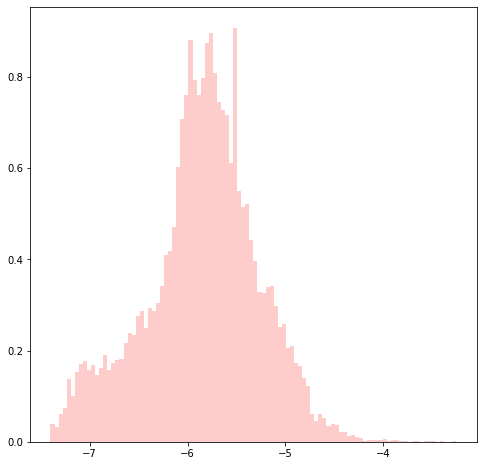

In [291]:
plt.figure(figsize=(8,8))
plt.hist(y, bins=100, density=True, alpha=0.2, color='red')
plt.draw()

In [292]:
# Need to chunk predictions, if GPU memory is not enough. This should be OK for 16 GB
chunked = True

samples_tab = np.reshape(samples.data, [-1,4])
y = np.zeros((samples_tab.shape[0],1))


if chunked:
    XX = torch.tensor(samples_tab[:samples_tab.shape[0]//4,:]).to(device)
    y[:samples_tab.shape[0]//4] = traced_cell(XX).cpu().detach().numpy()

    XX = torch.tensor(samples_tab[samples_tab.shape[0]//4:samples_tab.shape[0]//2,:]).to(device)
    y[samples_tab.shape[0]//4:samples_tab.shape[0]//2] = traced_cell(XX).cpu().detach().numpy()

    XX = torch.tensor(samples_tab[samples_tab.shape[0]//2:samples_tab.shape[0]//4*3,:]).to(device)
    y[samples_tab.shape[0]//2:samples_tab.shape[0]//4*3] = traced_cell(XX).cpu().detach().numpy()

    XX = torch.tensor(samples_tab[samples_tab.shape[0]//4*3:,:]).to(device)
    y[samples_tab.shape[0]//4*3:] = traced_cell(XX).cpu().detach().numpy()
else:
    XX = torch.tensor(samples_tab).to(device)
    y = traced_cell(XX).cpu().detach().numpy()

y = np.reshape(y, masks.shape)
y[~masks] = np.nan

print(np.sum(np.isnan(y)) - np.sum(~masks))


0


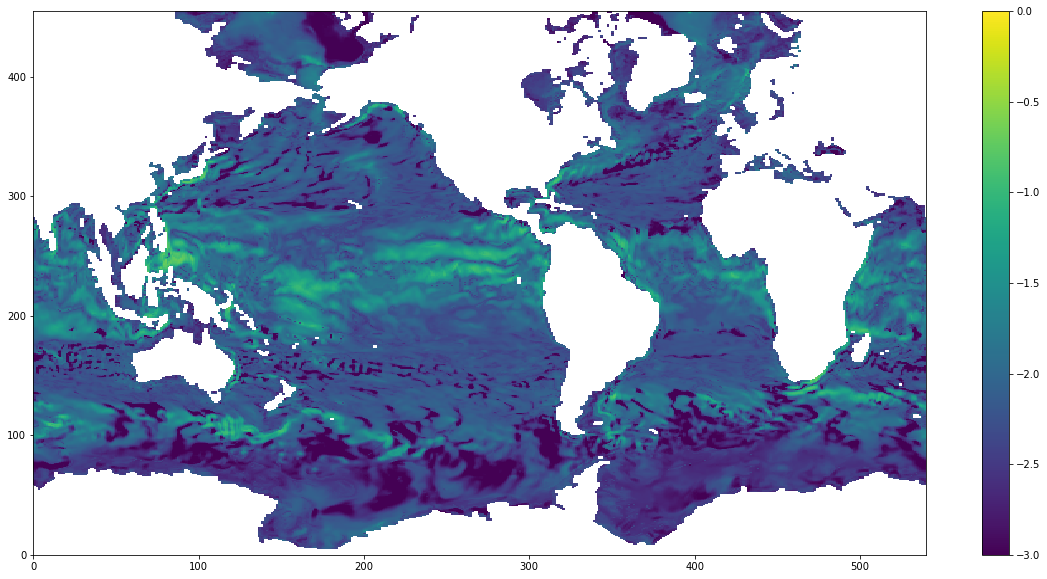

In [294]:
plt.figure(figsize=(20,10))
plt.pcolormesh(np.log10(np.exp(y.squeeze())), vmin=-3, vmax=-0.0)

plt.colorbar()
plt.draw()